In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### for reproducible experiments
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import numpy as np
import pandas as pd
import git
import mlflow.keras
import os, sys
from gensim.models.wrappers import FastText

#import tensorflow_hub as hub
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import random
%matplotlib inline
pd.set_option('display.max_rows', None)

sys.path.append('../citation_bio_trainer')
#from feature.SpacyFeaturizer import get_spacy_feats_from_text
from feature.Featurizer import Featurizer
from util.Utils import calulate_ser_jer, load_from_folder, pad_sequences, load_embedding_matrix, evaluate, log_mlflow_results
import warnings
from model.FTLSTM import calulate_ser_jer, get_model, plot_output
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [4]:
path = '/home/joshib/cs_data/citation-bio-labelled-data-2020-06-08~15:13:57.766608/nlp/exps/output/2020-06-08~15:13:57.766608'
#data_df = pd.read_csv(path+'/data-2020-06-08~15:14:01.185827.csv')

## LSTM with random embedding model

In [5]:
%%time
train_data_path = '/nlp/cs_mixed_20k/cs_mixed_20k_train/'
test_data_path  = '/nlp/cs_mixed_20k/cs_mixed_20k_test/'
eval_without_intra_newline_path  = '/nlp/eval_data_spacy_tokenized_extra_space_removed/'

sentences_train, sent_tags_train = load_from_folder(train_data_path)
sentences_test, sent_tags_test = load_from_folder(test_data_path)
sentences_eval1, sent_tags_eval1 = load_from_folder(eval_without_intra_newline_path)

CPU times: user 1min 27s, sys: 1.29 s, total: 1min 28s
Wall time: 1min 39s


In [6]:
xtrain, xvalid, ytrain, yvalid = train_test_split(sentences_train, sent_tags_train, test_size=0.1, random_state=42)

In [7]:
feat_config = {'max_vocab':100000,
               'lstm_feats':True, 
               'spacy_feats':True, 
               'google_feats': False, 
               'parscit_feats': True}

In [36]:
%%time
featurizer = Featurizer(feat_config)
print("loading train ...")
train_dict, tokenizer, maxlen = featurizer.fit_transform(xtrain, ytrain)
# print("loading valid ...")
# valid_dict = featurizer.transform(xvalid, yvalid)
# print("loading test ...")
# test_dict  = featurizer.transform(sentences_test, sent_tags_test)
# print("loading evals ...")
# eval1_dict  = featurizer.transform(sentences_eval1, sent_tags_eval1)

loading train ...
total partitions = 15
total partitions = 15
CPU times: user 11min 20s, sys: 20.5 s, total: 11min 40s
Wall time: 14min 37s


In [9]:
%%time
### Load from file
maxlen = 3861
train_dict={}
train_dict['labels'] = np.load('/nlp/temp/train_dict_labels.npy')
train_dict['lstm_feats']=np.load('/nlp/temp/train_dict_lstm_feats.npy')
train_dict['spacy_num_feats'] = np.load('/nlp/temp/train_dict_spacy_feats.npy')

valid_dict={}
valid_dict['labels']=np.load('/nlp/temp/valid_dict_labels.npy')
valid_dict['lstm_feats']=np.load('/nlp/temp/valid_dict_lstm_feats.npy')
valid_dict['spacy_num_feats']=np.load('/nlp/temp/valid_dict_spacy_feats.npy')

test_dict={}
test_dict['labels'] = np.load('/nlp/temp/test_dict_labels.npy')
test_dict['lstm_feats']=np.load('/nlp/temp/test_dict_lstm_feats.npy')
test_dict['spacy_num_feats']=np.load('/nlp/temp/test_dict_spacy_feats.npy')

eval1_dict={}
eval1_dict['labels'] = np.load('/nlp/temp/eval1_dict_labels.npy')
eval1_dict['lstm_feats']=np.load('/nlp/temp/eval1_dict_lstm_feats.npy')
eval1_dict['spacy_num_feats']=np.load('/nlp/temp/eval1_dict_spacy_feats.npy')

CPU times: user 3.22 s, sys: 2.6 s, total: 5.82 s
Wall time: 36.6 s


### Neural parscit features (temporary fix)

In [18]:
# %%time
# from feature.ParsCitLSTM import ParsCitLSTM
# c = {
#         "model_file": "/nlp/parscit/parscit-29-latest.h5",
#         "label_dict_file": "/nlp/parscit/labels.json",
#         "tfhub_model_dir": "/nlp/parscit/resource/"}
# model = ParsCitLSTM(model_config=c)

In [19]:
# %%time
# train_df = pd.DataFrame([])
# valid_df = pd.DataFrame([])
# test_df = pd.DataFrame([])
#eval1_df = pd.DataFrame([])

# train_df['text'] = np.array(xtrain, dtype='object')
# valid_df['text'] = np.array(xvalid, dtype='object')
# test_df['text'] = np.array(sentences_test, dtype='object')
#eval1_df['text'] = np.array(sentences_eval1, dtype='object')

In [20]:
#%%time
# train_parscit = model.get_parscit_blocks(train_df)
# valid_parscit = model.get_parscit_blocks(valid_df)
# test_parscit  = model.get_parscit_blocks(test_df)
#eval1_parscit = model.get_parscit_blocks(eval1_df, chunk_size=40)


# train_parscit = pd.read_pickle('/nlp/temp/train_parscit.pickle')
# valid_parscit = pd.read_pickle('/nlp/temp/valid_parscit.pickle')
# test_parscit = pd.read_pickle('/nlp/temp/test_parscit.pickle')
# eval1_parscit = pd.read_pickle('/nlp/temp/eval1_parscit.pickle')

In [51]:
def pad_dummy_feats(df, maxlen):
    parscit = df.copy()
    parscit_feats = list(parscit['parscit_feat']) 
    parscit_padded = []
    for ind in range(len(parscit_feats)):
        parscit_mask = np.zeros((maxlen, 14), dtype='int8')
        if len(parscit_feats[ind]) <= maxlen:
            parscit_mask[0:len(parscit_feats[ind]), :] = parscit_feats[ind][:]
        else:
            parscit_mask[:] = parscit_feats[ind][0:maxlen,:]
        parscit_padded.append(parscit_mask)
    parscit_arr = np.array([i.tolist() for i in parscit_padded])
    return parscit_arr

In [22]:
# %%time
# train_parscit_arr = pad_dummy_feats(train_parscit, maxlen)
# valid_parscit_arr = pad_dummy_feats(valid_parscit, maxlen)
# test_parscit_arr  = pad_dummy_feats(test_parscit, maxlen)
#eval1_parscit_arr = pad_dummy_feats(eval1_parscit, maxlen)

In [10]:
%%time
## load saved files
train_parscit_arr = np.load('/nlp/temp/train_parscit_arr.npy')
valid_parscit_arr = np.load('/nlp/temp/valid_parscit_arr.npy')
test_parscit_arr  = np.load('/nlp/temp/test_parscit_arr.npy')
eval1_parscit_arr = np.load('/nlp/temp/eval1_parscit_arr.npy')

CPU times: user 3.09 s, sys: 2.63 s, total: 5.72 s
Wall time: 36.4 s


## Keras with pre-trained fast text embedding

In [15]:
%%time
#wiki_model = FastText.load_fasttext_format('/nlp/cc.en.300.bin')
#embedding_matrix = load_embedding_matrix(wiki_model, feat_config['max_vocab'], tokenizer.word_index, 300)
embedding_matrix=np.load('/nlp/temp/embedding_matrix.npy')

CPU times: user 74.1 ms, sys: 77.6 ms, total: 152 ms
Wall time: 963 ms


In [16]:
model_config = {'embedding': {'use':True, 'matrix':embedding_matrix, 'trainable':True},## trainableTrue is significantly better 
                'lstm': {'use':True, 'num': 1, 'units':50, 'dropout':0.2},
                'dense':{'use':False, 'num': 1, 'units':32, 'activation': 'relu', 'dropout':0.2},
                'optimizer': Adam(
        learning_rate=0.001,
        beta_1=0.0,
        beta_2=0.0,
        epsilon=1e-05,
        amsgrad=False,
    ),
                'output_activation' : 'sigmoid', 
                'batch_size': 16, ## lower the better
                'aux_feats': {'use':True, 'dim':26, 'place':'before_lstm'}, 
                'timedistributed':{'use':False}, ## no difference at all True or False
                'shuffle': True ## not much different than False
                
               }

In [18]:
%%time
model = get_model(feat_config, model_config, maxlen)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3861)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3861, 300)    30000000    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3861, 26)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3861, 326)    0           embedding[0][0]                  
                                                                 input_2[0][0]                

In [17]:
%%time
if feat_config['spacy_feats'] and not feat_config['parscit_feats']:
    print('only spacy not parscit')
    train_aux = train_dict['spacy_num_feats']
    valid_aux = valid_dict['spacy_num_feats']
    test_aux  = test_dict['spacy_num_feats']
    eval1_aux  = eval1_dict['spacy_num_feats']
    
elif feat_config['spacy_feats'] and  feat_config['parscit_feats']:
    print("both spacy and parscit")
    train_aux = np.concatenate((train_dict['spacy_num_feats'], train_parscit_arr), axis=-1)
    valid_aux = np.concatenate((valid_dict['spacy_num_feats'], valid_parscit_arr), axis=-1)
    test_aux  = np.concatenate((test_dict['spacy_num_feats'], test_parscit_arr), axis=-1)
    eval1_aux  = np.concatenate((eval1_dict['spacy_num_feats'], eval1_parscit_arr), axis=-1)
else:
    print('only lstm features')
#eval1_aux = np.concatenate((eval_dict1['spacy_num_feats'], eval1_parscit_arr), axis=-1)
#eval2_aux = np.concatenate((eval_dict2['spacy_num_feats'], eval2_parscit_arr), axis=-1)

both spacy and parscit
CPU times: user 4.24 s, sys: 3.84 s, total: 8.08 s
Wall time: 8.07 s


multi input model
Epoch 1/100
989/989 [==============================] - 352s 356ms/step - loss: 0.0069 - accuracy: 0.9976 - val_loss: 8.6599e-04 - val_accuracy: 0.9997
Epoch 2/100
989/989 [==============================] - 352s 356ms/step - loss: 6.6979e-04 - accuracy: 0.9998 - val_loss: 4.2897e-04 - val_accuracy: 0.9999
Epoch 3/100
989/989 [==============================] - 351s 355ms/step - loss: 3.4184e-04 - accuracy: 0.9999 - val_loss: 2.2599e-04 - val_accuracy: 0.9999
Epoch 4/100
989/989 [==============================] - 351s 355ms/step - loss: 2.1539e-04 - accuracy: 0.9999 - val_loss: 1.7560e-04 - val_accuracy: 0.9999
Epoch 5/100
989/989 [==============================] - 351s 355ms/step - loss: 1.7054e-04 - accuracy: 0.9999 - val_loss: 2.1069e-04 - val_accuracy: 0.9999
Epoch 6/100
989/989 [==============================] - 352s 356ms/step - loss: 1.4086e-04 - accuracy: 1.0000 - val_loss: 1.2582e-04 - val_accuracy: 1.0000
Epoch 7/100
989/989 [==============================] - 3

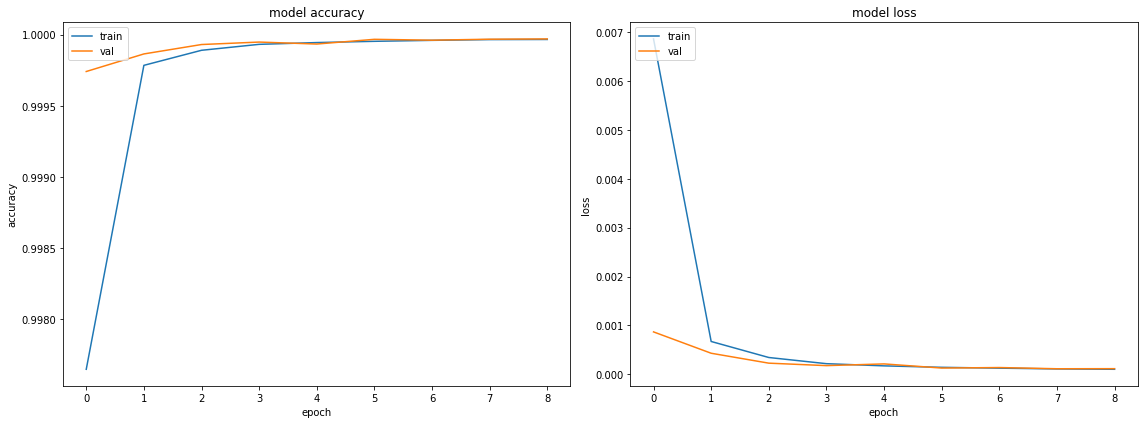

In [20]:
%%time
early_stop= EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min',restore_best_weights=False, min_delta=0.0001)

## multi input
if model_config['aux_feats']['use']:
    print("multi input model")
    history = model.fit([train_dict['lstm_feats'], train_aux], train_dict['labels'], verbose=1, epochs=100, batch_size= model_config['batch_size'], \
                    validation_data=([valid_dict['lstm_feats'], valid_aux], valid_dict['labels']), callbacks=[early_stop], shuffle=model_config['shuffle'])
else:
    print("single input model")
    history = model.fit(train_dict['lstm_feats'], train_dict['labels'], verbose=1, epochs=100, batch_size= model_config['batch_size'], \
                        validation_data=(valid_dict['lstm_feats'], valid_dict['labels']), callbacks=[early_stop], shuffle=model_config['shuffle'])

plot_output(history)

In [21]:
print('done')

done


### Analysis on validation data

In [26]:
%%time
keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
if model_config['aux_feats']['use']:
    valid_probs = keras_model.predict([valid_dict['lstm_feats'], valid_aux])
else:
    valid_probs = keras_model.predict(valid_dict['lstm_feats'])

valid_probs = valid_probs.reshape(valid_probs.shape[0], valid_probs.shape[1])
valid_preds = np.where(valid_probs > 0.5, 1, 0)

valid_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(valid_dict['labels'], yvalid)]
valid_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(valid_preds, yvalid)]
result_valid = evaluate(valid_true_ls, valid_pred_ls)

CPU times: user 18.4 s, sys: 3.32 s, total: 21.7 s
Wall time: 15.4 s


In [27]:
result_valid

{'count': 1758,
 'mean_ser': 0.002670961444572739,
 'mean_jer': 0.0034327840201287072,
 'mean_acc': 0.9998156923892054,
 'num_mistakes_seq': 191,
 'num_mistakes_all': 247}

In [41]:
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
count_valid = 0
#valid_df = pd.DataFrame([])
valid_ls = []
for ind in range(len(valid_preds)):
    temp_ls = []
    pred = valid_preds[ind]
    true = valid_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_valid += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            for x in fp_ind:
                valid_ls.append([ind, 'FP'] + np.array(xvalid[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                valid_ls.append([ind, 'FN'] + np.array(xvalid[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])

In [40]:
valid_mistakes_df = pd.DataFrame(valid_ls, columns=['index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

### Analysis of test result

In [28]:
%%time
keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
if model_config['aux_feats']['use']:
    test_probs = keras_model.predict([test_dict['lstm_feats'], test_aux])
else:
    test_probs = keras_model.predict(test_dict['lstm_feats'])
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[1])
test_preds = np.where(test_probs > 0.5, 1, 0)

test_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(test_dict['labels'], sent_tags_test)]
test_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(test_preds, sent_tags_test)]
result_test = evaluate(test_true_ls, test_pred_ls)


CPU times: user 20.4 s, sys: 3.67 s, total: 24.1 s
Wall time: 17.3 s


In [29]:
result_test

{'count': 1953,
 'mean_ser': 0.002312233117391255,
 'mean_jer': 0.0023378004500377767,
 'mean_acc': 0.9998626190315792,
 'num_mistakes_seq': 177,
 'num_mistakes_all': 215}

In [23]:
# tags = {'dataset':'cs_mixed_20k', 'data_split':'test', 'version':2} 
# del model_config['embedding']['matrix'] 
# opt = model_config['optimizer']
# model_config['optimizer'] = str(opt.get_config())
# log_mlflow_results(model, result_test, feat_config, model_config, tags)

In [42]:
count_test = 0
test_ls = []
for ind in range(len(test_preds)):
    temp_ls = []
    pred = test_preds[ind]
    true = test_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_test += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            for x in fp_ind:
                test_ls.append([ind, 'FP'] + np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                test_ls.append([ind, 'FN'] + np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4])

In [43]:
test_mistakes_df = pd.DataFrame(test_ls, columns=['index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

In [92]:
test_mistakes_df = test_mistakes_df.replace('\n', 'newline')

In [93]:
test_mistakes_df.to_csv('../test_mistakes_df.csv')

### Evaluation of eval dataset

In [19]:
%%time
keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/a8c17d8fbf7d43cebeae45efd3e7701f/artifacts/models")

CPU times: user 3.73 s, sys: 1.73 s, total: 5.45 s
Wall time: 3.41 s


In [20]:
if model_config['aux_feats']['use']:
    eval1_probs = keras_model.predict([eval1_dict['lstm_feats'], eval1_aux])
else:
    eval1_probs = keras_model.predict(eval1_dict['lstm_feats'])
eval1_probs = eval1_probs.reshape(eval1_probs.shape[0], eval1_probs.shape[1])
eval1_preds = np.where(eval1_probs > 0.5, 1, 0)


eval1_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(eval1_dict['labels'], sent_tags_eval1)]
eval1_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(eval1_preds, sent_tags_eval1)]
result_eval1 = evaluate(eval1_true_ls, eval1_pred_ls)

In [21]:
result_eval1

{'count': 1328,
 'mean_ser': 4.210459340312366e-05,
 'mean_jer': 0.0012718360205381972,
 'mean_acc': 0.9999653166676167,
 'num_mistakes_seq': 42,
 'num_mistakes_all': 84}

### Visualize errors

In [22]:
count_eval1 = 0
eval1_ls = []
for ind in range(len(eval1_preds)):
    temp_ls = []
    pred = eval1_preds[ind]
    true = eval1_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_eval1 += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            print(ind, 'fp', fp_ind)
            for x in fp_ind:
                #print(fp_ind)
                eval1_ls.append([ind, 'FP'] + np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            print(ind, 'fn', fn_ind)
            for x in fn_ind:
                eval1_ls.append([ind, 'FN'] + np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4])

6 fn [507]
30 fn [570]
35 fn [17 43]
180 fn [1879 2170]
236 fp [2698 3591]
242 fn [126]
261 fn [276]
283 fn [3789 3828]
312 fn [48]
335 fn [2603]
484 fn [1653]
521 fp [2826]
572 fn [1941]
664 fn [21]
681 fn [2352]
694 fn [2915 3134 3232 3271 3318 3341 3369 3427 3456 3501 3536 3629 3673]
716 fn [1374]
758 fn [55 77 97]
760 fn [48]
801 fn [16]
841 fn [1458 1468 1495 1517 1548 1706]
845 fn [1024]
871 fn [ 15 214]
932 fn [81]
934 fn [22]
948 fn [3222]
954 fn [2113]
992 fn [0]
1005 fn [  92 2987]
1007 fn [  91  111  140  546 1393]
1030 fn [3058 3742 3783 3834]
1047 fn [418]
1079 fp [3205]
1094 fn [25]
1130 fn [29]
1135 fn [1486 1514 1531 1795 1934 3067]
1153 fn [16]
1193 fn [1734]
1247 fn [695]
1253 fn [1163 1673 2034]
1263 fn [588]
1287 fn [3708 3743 3789 3831]


In [23]:
eval_mistakes_df = pd.DataFrame(eval1_ls, columns=['index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

In [24]:
eval_mistakes_df

,index,error_type,x-3,x-2,x-1,x,x+1,x+2,x+3
0,6,FN,47,.,\n,13.Unluhizarci,K,",",Gokce
1,30,FN,1125,.,\n,"""",16,.,Institute
2,35,FN,Oaks,.,\n,American,Psychiatric,Association,.
3,35,FN,DC,.,\n,Backhans,",",M.C.,","
4,180,FN,Manual,.,\n,53,.,International,iron
5,180,FN,),.,\n,60,.,Crossin,E.
6,236,FP,keratin,14,\n,phenotype,by,keratin,16
7,236,FP,Introducing,a,\n,mutation,in,the,mouse
8,242,FN,),.,\n,[,5]J.,Bruix,","
9,261,FN,-,20,\n,[,11,],P.Jacquelyn


In [25]:
eval_mistakes_df.to_csv('./eval_mistakes_df.csv', index=False)

In [30]:
len(sentences_eval1[1287].split(" "))

4720

In [ ]:
### Save eval results to file

In [60]:
min(len(sentences_eval1[ind].split(" ")), maxlen)

3861

In [41]:
ind = 0
eval_path_dict = {}
for fpath in os.listdir(eval_without_intra_newline_path):
    if fpath not in ['data-gen-config.json', 'data_generation_stats.csv'] and ".csv" in fpath:
        eval_path_dict[ind] = fpath
        ind += 1

In [66]:
min(len(sentences_eval1[75].split(" ")), maxlen)

3861

In [65]:
len(eval_preds1[75])

3861

In [71]:
eval_folder_path = '/nlp/eval_data_retok_predictions_f3a9cc61e30f460499b95a4c2b7957ae'
if not os.path.exists(eval_folder_path):
    os.makedirs(eval_folder_path)
for ind in range(len(eval_preds1)):
    #print(ind)
    df = pd.DataFrame([], columns=['x', 'y'])
    seq_len = min(len(sentences_eval1[ind].split(" ")), maxlen)
    df['x'] = sentences_eval1[ind].split(" ")[0:seq_len]
    df['y'] = eval_preds1[ind][0:seq_len]
    df.to_csv(os.path.join(eval_folder_path, eval_path_dict[ind][0:-4] + '_pred.csv'))

In [32]:
tags = {'dataset':'cs_mixed_20k', 'data_split':'eval_with_intra_newline_path','version':2}
#del model_config['embedding']['matrix'] 
#opt = model_config['optimizer']
#model_config['optimizer'] = str(opt.get_config())
log_mlflow_results(keras_model, result_eval1, feat_config, model_config, tags)

2020/08/18 16:23:24 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under s3://caps-s3-mlflow/artifacts/4/a8c17d8fbf7d43cebeae45efd3e7701f/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


In [ ]:
sentences_train[0][0:500]

In [ ]:
from feature.ParsCitLSTM import ParsCitLSTM

In [ ]:
#df = pd.read_csv('/nlp/parscit/data.csv')

In [ ]:
df = pd.DataFrame([])
df['text'] = np.array(sentences_train[0:100], dtype='object')

In [ ]:
%%time
df_out = model.dask_predict(df)

In [ ]:
#df_out

In [ ]:
# %%time
# import dask.dataframe as dd
# parscit_df = model.get_parscit_dask(df, blocksize=10)

In [ ]:
len(sentences_train[0].split(" "))

In [ ]:
%%time
x,y,z = model.predict(sentences_train[0])

In [ ]:
# for i,j in zip(x,y):
#     print(i,j)

### One predict test

In [ ]:
# model = load_model(c['model_file'])
# model._name='parscit_model'

In [ ]:
ls = np.random.randint(10, size=(1000))

In [ ]:
df = pd.DataFrame([], columns=['num'])
df['num'] = ls

In [ ]:
%%time
import pandas as pd
train_parscit = pd.read_pickle('/nlp/temp/train_parscit.pickle')
valid_parscit = pd.read_pickle('/nlp/temp/valid_parscit.pickle')
test_parscit = pd.read_pickle('/nlp/temp/test_parscit.pickle')
eval1_parscit = pd.read_pickle('/nlp/temp/eval1_parscit.pickle')
eval2_parscit = pd.read_pickle('/nlp/temp/eval2_parscit.pickle')

In [ ]:
def pad_dummy_feats(parscit, maxlen):
    parscit_feats = list(parscit['parscit_feat']) 
    parscit_padded = []
    for ind in range(len(parscit_feats)):
        parscit_mask = np.zeros((maxlen, 14), dtype='int8')
        if len(parscit_feats[ind]) <= maxlen:
            parscit_mask[0:len(parscit_feats[ind]), :] = parscit_feats[ind][:]
        else:
            parscit_mask[:] = parscit_feats[ind][0:maxlen,:]

        parscit_padded.append(parscit_mask)
    parscit_arr = np.array([i.tolist() for i in parscit_padded])
    return parscit_arr

In [59]:
# %%time
# np.save('/nlp/temp/train_dict_labels.npy', train_dict['labels'])
# np.save('/nlp/temp/train_dict_lstm_feats.npy', train_dict['lstm_feats'])
# np.save('/nlp/temp/train_dict_spacy_feats.npy', train_dict['spacy_num_feats'])

# np.save('/nlp/temp/valid_dict_labels.npy', valid_dict['labels'])
# np.save('/nlp/temp/valid_dict_lstm_feats.npy', valid_dict['lstm_feats'])
# np.save('/nlp/temp/valid_dict_spacy_feats.npy', valid_dict['spacy_num_feats'])

# np.save('/nlp/temp/test_dict_labels.npy', test_dict['labels'])
# np.save('/nlp/temp/test_dict_lstm_feats.npy', test_dict['lstm_feats'])
# np.save('/nlp/temp/test_dict_spacy_feats.npy', test_dict['spacy_num_feats'])

In [195]:
np.save('/nlp/temp/eval1_dict_labels.npy', eval1_dict['labels'])
np.save('/nlp/temp/eval1_dict_lstm_feats.npy', eval1_dict['lstm_feats'])
np.save('/nlp/temp/eval1_dict_spacy_feats.npy', eval1_dict['spacy_num_feats'])

In [201]:
np.save('/nlp/temp/eval1_parscit_arr.npy', eval1_parscit_arr)

In [9]:
for ind in range(100):
    print(np.array(sentences_train[ind].split(" "))[np.where(np.array(sent_tags_train[ind].split(" ")) == "B-CIT")])

['1' '2' '3' '4' '5' '6' '7' '8)' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24']
['Griffiths' 'Griffiths' 'Haferkamp' 'Ho' 'Ho' 'Ho' 'Hughes' 'Jenkins'
 'Johnson' 'Joinson' 'Kapidzic' 'Kim' 'Kuss' 'Lapinski' 'LaRose' 'LaRose'
 'LaRose' 'Leary' 'Ledbetter' 'Lee' 'Lee' 'Lee' 'Lee' 'Liao' 'Lin' 'Lu'
 'Mark' 'Meece' 'Mehdizadeh' 'Ministry' 'Muller' 'Orchard' 'Özguven'
 'Patchin' 'Pelling' 'Prencipe' 'Quiñones' 'Rock' 'Ross' 'Santrock'
 'Scheres' 'Seidman' 'Skues' 'Stryker' 'Sundar' 'Tandoc' 'Tarafdar'
 'Turel' 'Urban' 'Utz' 'Utz' 'Van' 'Vogel' 'Weinstein' 'Wiederhold'
 'Wilson' 'Yan' 'Yao' 'Yao' 'Yu' 'Zhang' 'Zywica' 'T.']
['Y.' 'https://www-nds.iaea.org/exfor/exfor.html' 'A.' 'S.K.' 'Ion'
 'Sumitomo' 'Food' 'Hamilton' 'Human' 'Qi' 'World' 'I.' 'F.' 'F.' 'F.C.']
['(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '('
 '(' '(' '(' '(']
['[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '[' '['
 '[' '[' '[' '[' '[' '[' '[' '[']

In [10]:
np.where(np.array(sent_tags_train[0].split(" ")) == "B-CIT")

(array([  0,  62, 112, 117, 121, 154, 182, 238, 326, 373, 404, 492, 540,
        609, 639, 664, 706, 751, 835, 865, 897, 939, 969, 995]),)

In [94]:
#sentences_train[0]

In [146]:
count = 0
eval_without_intra_newline_path  = '/nlp/eval_data_multi_space_removed/'
#test_data_path  = '/nlp/cs_mixed_20k/cs_mixed_20k_test/'
for fpath in os.listdir(eval_without_intra_newline_path)[0:1]:
    #print(fpath)
    if fpath not in ['data-gen-config.json', 'data_generation_stats.csv'] and ".csv" in fpath:
        fpath = os.path.join(eval_without_intra_newline_path, fpath)
        df = pd.read_csv(fpath, index_col=0)
        df.fillna("\n", axis=1, inplace=True)
        if len(df[(df.x==" ")]) :
            print(fpath)
            count += 1

In [147]:
df

,x,y
0,"Aydin,",B-CIT
1,"S.,",I-CIT
2,"Kuloglu,",I-CIT
3,"T.,",I-CIT
4,"Aydin,",I-CIT
5,"S.,",I-CIT
6,"Eren,",I-CIT
7,"M.N.,",I-CIT
8,"Yilmaz,",I-CIT
9,"M.,",I-CIT


In [104]:
sent_tags_test[614].split(" ")

['B-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'B-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'B-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'B-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',
 'I-CIT',


In [120]:
df[df.y == 'B-CIT']

,x,y
0,CARE,B-CIT
30,International,B-CIT
63,Vaccine,B-CIT
89,Bottini,B-CIT
150,Gartner,B-CIT
177,Steil,B-CIT
205,Gonenc,B-CIT
255,Water,B-CIT
286,Anderson,B-CIT
319,Eberlein,B-CIT


In [31]:
from keras.models import load_model, save_model

In [32]:
save_model(keras_model, 'saved_keras_model.h5')

In [35]:
%%time
bla = load_model('./saved_keras_model.h5')

CPU times: user 1.08 s, sys: 825 ms, total: 1.91 s
Wall time: 1.12 s


In [37]:
featurizer

In [38]:
import pickle

In [41]:
%%time
with open('test.pkl', 'wb') as f:
    pickle.dump(featurizer, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 355 ms, sys: 7.69 ms, total: 362 ms
Wall time: 362 ms


In [44]:
%%time
with open('test.pkl', 'rb') as f:
    fload = pickle.load(f)

CPU times: user 347 ms, sys: 7.95 ms, total: 355 ms
Wall time: 354 ms


In [60]:
%%time
ind = 4
sample_dict = fload.transform(sentences_eval1[ind:ind+1])

total partitions = 1
CPU times: user 26.9 ms, sys: 1.86 s, total: 1.88 s
Wall time: 5.79 s


In [53]:
%%time
from feature.ParsCitLSTM import ParsCitLSTM
c = {
        "model_file": "/nlp/parscit/parscit-29-latest.h5",
        "label_dict_file": "/nlp/parscit/labels.json",
        "tfhub_model_dir": "/nlp/parscit/resource/"}
pmodel = ParsCitLSTM(model_config=c)

CPU times: user 20.2 s, sys: 1.47 s, total: 21.7 s
Wall time: 21.1 s


In [56]:
%%time
sample_df = pd.DataFrame([])
sample_df['text'] = np.array(sentences_eval1[ind:ind+1], dtype='object')
sample_parscit = pmodel.get_parscit_blocks(sample_df)
sample_parscit_arr = pad_dummy_feats(sample_parscit, maxlen)

100%|██████████| 1/1 [00:08<00:00,  8.50s/it]

CPU times: user 8.43 s, sys: 33.5 ms, total: 8.46 s
Wall time: 8.52 s


In [57]:
%%time
sample_aux  = np.concatenate((sample_dict['spacy_num_feats'], sample_parscit_arr), axis=-1)
sample_probs = keras_model.predict([sample_dict['lstm_feats'], sample_aux])
sample_probs = sample_probs.reshape(sample_probs.shape[0], sample_probs.shape[1])
sample_preds = np.where(sample_probs > 0.5, 1, 0)

CPU times: user 177 ms, sys: 16.5 ms, total: 194 ms
Wall time: 196 ms
